# Image Classifier using 102 Flowers Dataset
##### SHARAN SK

The dataset : "102 flowers Dataset" has been downloaded onto the drain and has been split into train,valid and test category.The program uses Pytorch API and utilizes the CUDA Support for GPU Training

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import torch
from PIL import Image
import matplotlib.gridspec as gridspec
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
import json

## Load the data

The model data has been uploaded in the drive and will be extracted from the drive for train and testing
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy.io import loadmat
labels = loadmat('/content/drive/MyDrive/sem6/Dataset_flowers/imagelabels.mat')
setid = loadmat('/content/drive/MyDrive/sem6/Dataset_flowers/setid.mat')

In [ ]:
setid

In [ ]:
#  Define your transforms for the training, validation, and testing sets
'''Our model is going to require a 224x244 image size, so we are going to resize them to that specification'''
data_transforms = {
    'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'test' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}


#  Load the datasets with ImageFolder
image_data = {
    'train' : datasets.ImageFolder("/content/drive/MyDrive/sem6/Dataset_flowers/", transform=data_transforms['train']),
    'test' : datasets.ImageFolder("/content/drive/MyDrive/sem6/Dataset_flowers/", transform=data_transforms['test']),
    'validation' : datasets.ImageFolder("/content/drive/MyDrive/sem6/Dataset_flowers/", transform=data_transforms['validation'])
}

#  Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train' : torch.utils.data.DataLoader(image_data['train'], batch_size=64, shuffle=True),
    'test' : torch.utils.data.DataLoader(image_data['test'], batch_size=64, shuffle=False),
    'validation' : torch.utils.data.DataLoader(image_data['validation'], batch_size=64, shuffle=True)
}

class_to_idx = image_data['train'].class_to_idx

In [ ]:
#Function to display tensor images. 
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

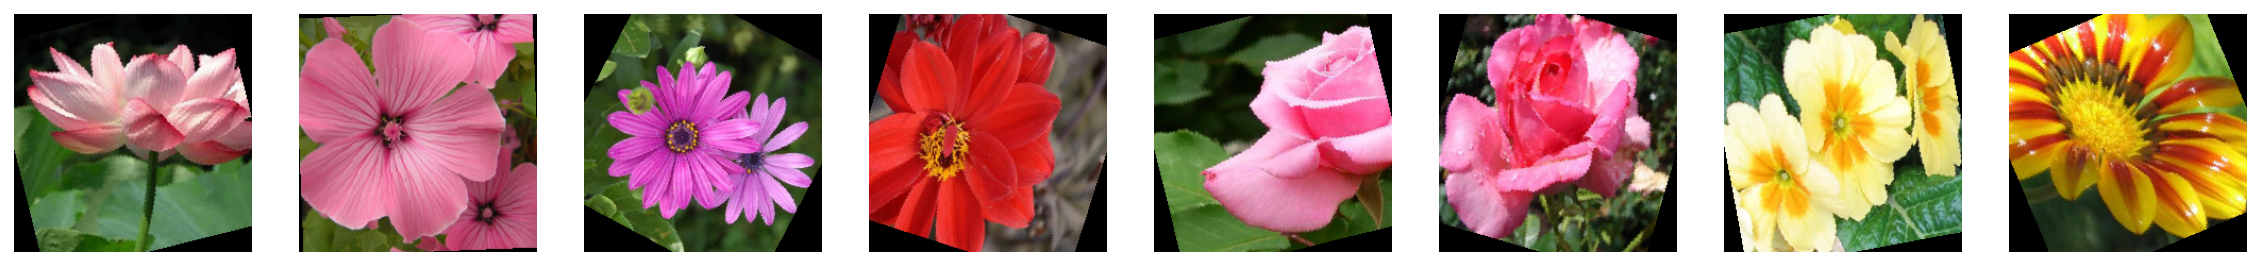

In [ ]:
#Displaying images from teh training loader. 
data_iter = iter(dataloaders["train"])
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(20,8), ncols=8)
for ii in range(8):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    

### Label mapping


In [ ]:
with open('/content/drive/MyDrive/sem6/Dataset_flowers/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

#Training the classifier using resnet18



In [ ]:
# Import Model Resnet 
model = models.vgg19(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# Weights of pretrained model are frozen 
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p= 0.02)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replace with the pretrained classifier 
model.classifier = classifier
#  Train a model with a pre-trained network

# Recommended 
criterion = nn.NLLLoss()
# Using Adam optimiser 
optimizer = optim.Adam(model.classifier.parameters(), lr= 0.0008)

In [ ]:
# Implement a function for  validation 
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [ ]:
epochs = 10
steps = 0
print_every = 30

# change to gpu mode
model.to('cuda')

for e in range(epochs):
    since = time.time()
    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(dataloaders['train']):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, dataloaders['validation'], criterion)
                
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(dataloaders['validation']),3)} \
            Valid Accuracy: {round(float(accuracy/len(dataloaders['validation'])),3)}")
            
            running_loss = 0
            
            # Turning training back on
            model.train()
            
    time_taken = time.time() - since
    print(f"Time taken for epoch: {time_taken} seconds")

## Testing your network



In [ ]:
model.eval() #this turns our model to validation/inference mode
test_loss = 0
accuracy = 0
            
for images, labels in dataloaders['test']:
    images, labels = images.to('cuda'), labels.to('cuda')
                
    logps = model(images)
    loss = criterion(logps, labels)
    test_loss += loss.item()
                
    #Calculate our accuracy
    ps = torch.exp(logps)
    top_ps, top_class = ps.topk(1, dim=1)
    equality = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equality.type(torch.FloatTensor))
    
print(f"Test loss: {test_loss/len(dataloaders['test']):.3f}.. "
    f"Test accuracy: {accuracy/len(dataloaders['test']):.3f}")        



Test loss: 0.546.. Test accuracy: 0.841


## Save the checkpoint



In [ ]:
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 102,
                  'state_dict': model.state_dict(),
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'my_checkpoint1.pth')

## Loading the checkpoint



In [ ]:

# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    model = models.vgg19()
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p= 0.02)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('my_checkpoint1.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [ ]:
# Testing checkpoint

loaded_model.eval()
images, labels = next(iter(dataloaders['test']))
output = loaded_model.forward(Variable(images[:2]))
ps = torch.exp(output).data
print(ps.max(1)[1])

tensor([ 0, 66])


In [ ]:

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:
# TODO: Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

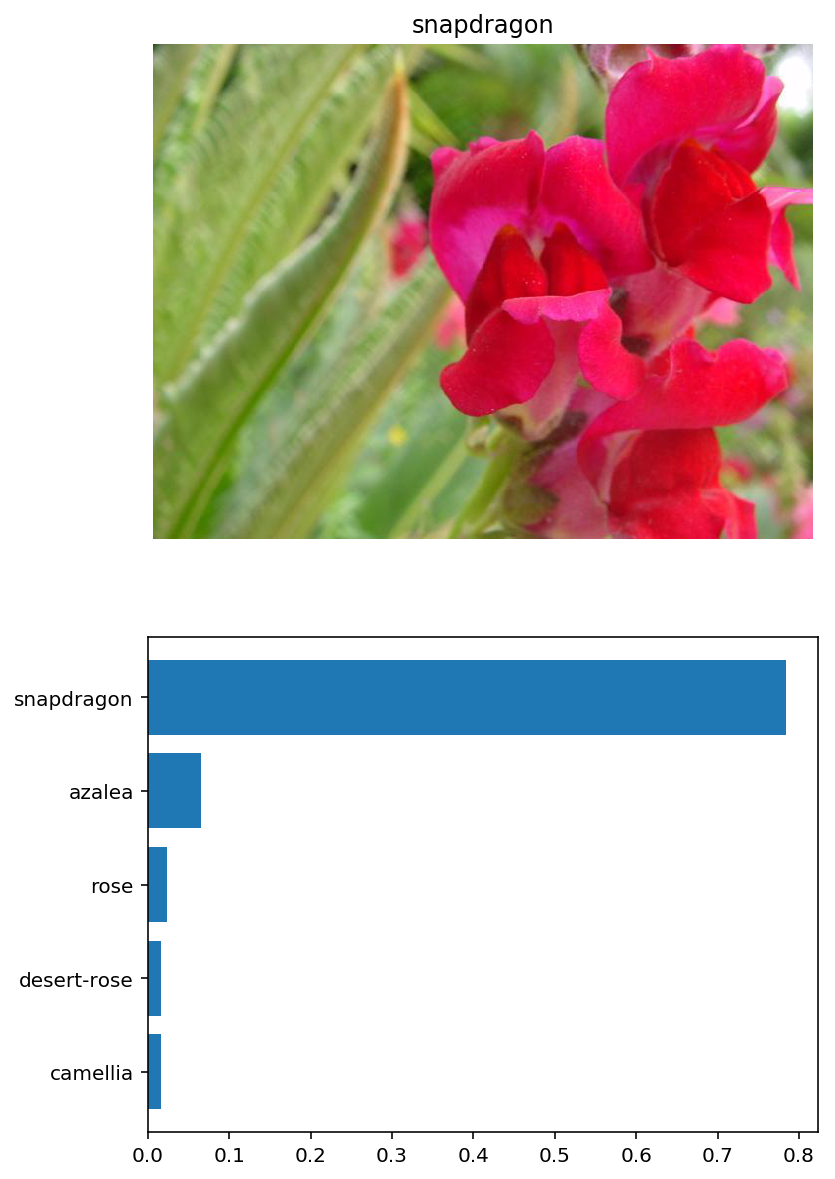

In [ ]:
#Test 1: 
img = 'flowers_data//test/11/image_03115.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

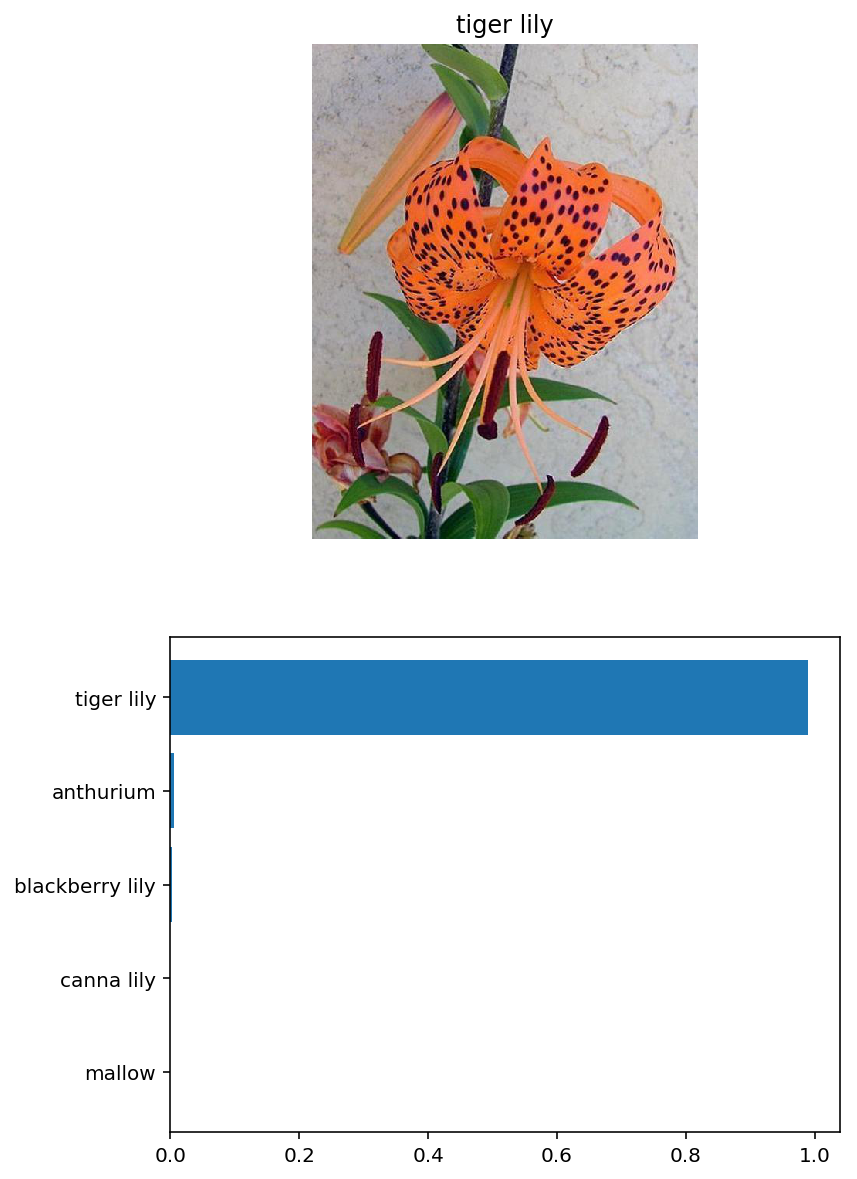

In [ ]:
#Test 2
img = 'flowers_data//test/6/image_07182.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

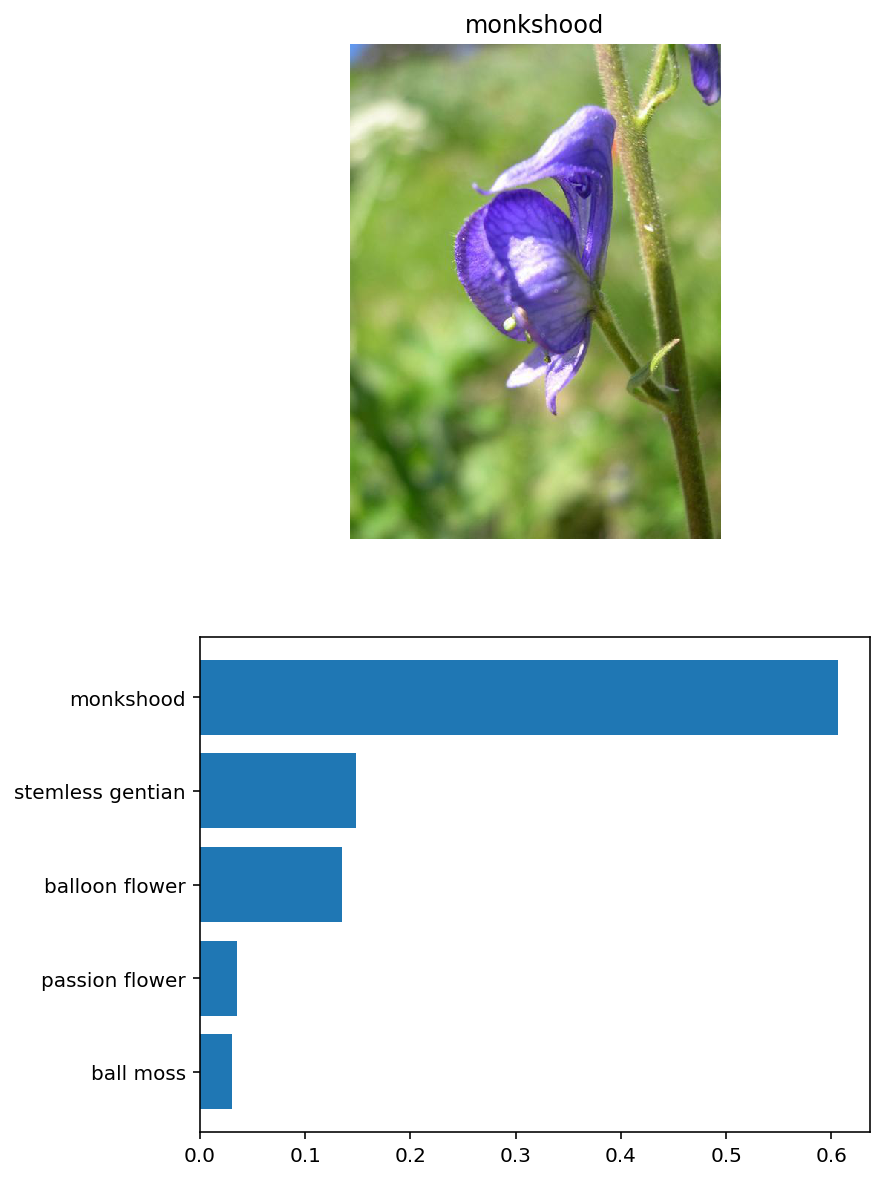

In [ ]:
#Test 3
img = 'flowers_data//test/9/image_06410.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)